#1. Import the necessary libraries:

1.   List item
2.   List item



In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Access Google Drive Folder
import os
COLAB_PATH = "gdrive/MyDrive"
os.chdir(COLAB_PATH)

In [ ]:
# Enter to yolov7 folder
%cd resnetCarpet
!ls

/content/gdrive/MyDrive/resnetCarpet
best_model_weights.pth	data  resnetSplit.zip  save_0.pth  weights


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

import torch.optim as optim
import torch.utils.data as data
import random
import pandas as pd
import seaborn as sn

# 2. Set up the data loading and preprocessing

In [ ]:
# Unzip Dataset
#!unzip ./resnetSplit.zip -d ./data/

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_dataset = torchvision.datasets.ImageFolder(root='data/resnetSplit/train', transform=transform)
val_dataset = torchvision.datasets.ImageFolder(root='data/resnetSplit/validation', transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root='data/resnetSplit/test', transform=transform)

batch_size = 32

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [ ]:
print(len(train_loader), len(val_loader))

62 8


In [ ]:
class_labels = train_dataset.classes
class_labels

['bad_carpet', 'good_carpet']

## 2. No Cross Validation

### 2.2 Define the ResNet-101 model:

In [ ]:
model = torchvision.models.resnet101(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # 10 is the number of classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### 2.3 Set up the loss function and optimizer:

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### 2.4 Train the model:

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
history = {'train_loss':[],'val_acc':[] , 'train_acc': [], 'val_loss':[]}

def train(model, train_loader, val_loader=None, num_epochs=2, save=True):
  best_loss = float('inf')  # Initialize with a high value for comparison
  for epoch in range(num_epochs):
      # Training code...
      model.train()
      running_loss = 0.0
      epoch_loss = 0.0
      correct_train_predictions = 0
      total_train_predictions = 0
      '''  for inputs, labels in train_loader: '''
      for i, (inputs, labels) in enumerate(train_loader, 0):
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()

          outputs = model(inputs)
          _, predicted = torch.max(outputs.data, 1)  # Calculate predictions here
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          epoch_loss += loss.item()

          # Increment correct predictions
          correct_train_predictions += (predicted == labels).sum().item()
          total_train_predictions += labels.size(0)
          if (i % 10) == 9:    # print every 10 mini-batches
              print('[Epoch: %d, Batch: %4d / %4d], training loss: %.3f' %
                  (epoch + 1, i + 1, len(train_loader), running_loss / 10))
              running_loss = 0.0

       # After all batches, calculate accuracy
      training_accuracy = 100 * correct_train_predictions / total_train_predictions
      print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, epoch_loss/len(train_loader)))
      history['train_loss'].append(epoch_loss/len(train_loader))
      history['train_acc'].append(training_accuracy)


      # Validation code...
      if val_loader:
        model.eval()
        validation_loss = 0.0

        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)

                loss = criterion(outputs, labels)
                validation_loss += loss.item()

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        history['val_loss'].append(validation_loss)
        history['val_acc'].append(accuracy)
        print('Validation Accuracy: {:.2f}%'.format(accuracy))
        print('Best Validation Loss: {:.3f}'.format(best_loss))
        print('Validation Loss: {:.3f}'.format(validation_loss))

        # Check if current model has the best loss
        if validation_loss < best_loss:
            best_loss = validation_loss
            torch.save(model.state_dict(), 'best_model_weights.pth')



        # save the model
        if save:
            torch.save(model.state_dict(), "save_" + str(epoch) + ".pth")

  print("Training finished.")

train(model, train_loader, val_loader, 1, True)

[Epoch: 1, Batch:   10 /   62], training loss: 0.308
[Epoch: 1, Batch:   20 /   62], training loss: 0.339
[Epoch: 1, Batch:   30 /   62], training loss: 0.313
[Epoch: 1, Batch:   40 /   62], training loss: 0.247
[Epoch: 1, Batch:   50 /   62], training loss: 0.277
[Epoch: 1, Batch:   60 /   62], training loss: 0.277
Epoch [1/1], Loss: 0.2938
Validation Accuracy: 87.76%
Best Validation Loss: inf
Validation Loss: 2.491
Training finished.


### 2.5 Save the last weights (not the best).

In [ ]:
# Save the model's state dictionary or specific parameters
#torch.save(model.state_dict(), 'model_last_weights.pth')

### 2.6 Load the weights if needed.

In [ ]:
# Load the saved weights
#model.load_state_dict(torch.load('./best_model_weights.pth'))
model.load_state_dict(torch.load('../yolov7/weights/best_model_weights_epoch_2.pth'))

<All keys matched successfully>

### 2.7 Test Model

In [ ]:
import torch

# Assuming test_loader, model, and criterion are already defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Initialize lists to store predictions, labels, and probabilities
all_preds = []
all_labels = []
all_probs = []

# Initialize variables for test loss and accuracy computation
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader, 0):
        print('Batch [%4d / %4d]' % (i+1, len(test_loader)))
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Convert outputs to probabilities
        probabilities = torch.softmax(outputs, dim=1)
        all_probs += list(probabilities.cpu().numpy())

        # Get predictions
        _, preds = torch.max(outputs, 1)
        all_preds += list(preds.cpu().numpy())
        all_labels += list(labels.cpu().numpy())

        # Update total and correct
        total += labels.size(0)
        correct += (preds == labels).sum().item()

# Compute the accuracy
accuracy = 100 * correct / total
print('Test Loss: {:.4f}'.format(test_loss / len(test_loader)))
print('Test Accuracy: {:.2f}%'.format(accuracy))

Batch [   1 /    8]
Batch [   2 /    8]
Batch [   3 /    8]
Batch [   4 /    8]
Batch [   5 /    8]
Batch [   6 /    8]
Batch [   7 /    8]
Batch [   8 /    8]
Test Loss: 0.5653
Test Accuracy: 69.64%


In [ ]:
classes= train_dataset.classes
classes

['bad_carpet', 'good_carpet']

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score

cm = confusion_matrix(all_labels, all_preds);
cm

array([[101,  28],
       [  7, 111]])

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="black" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


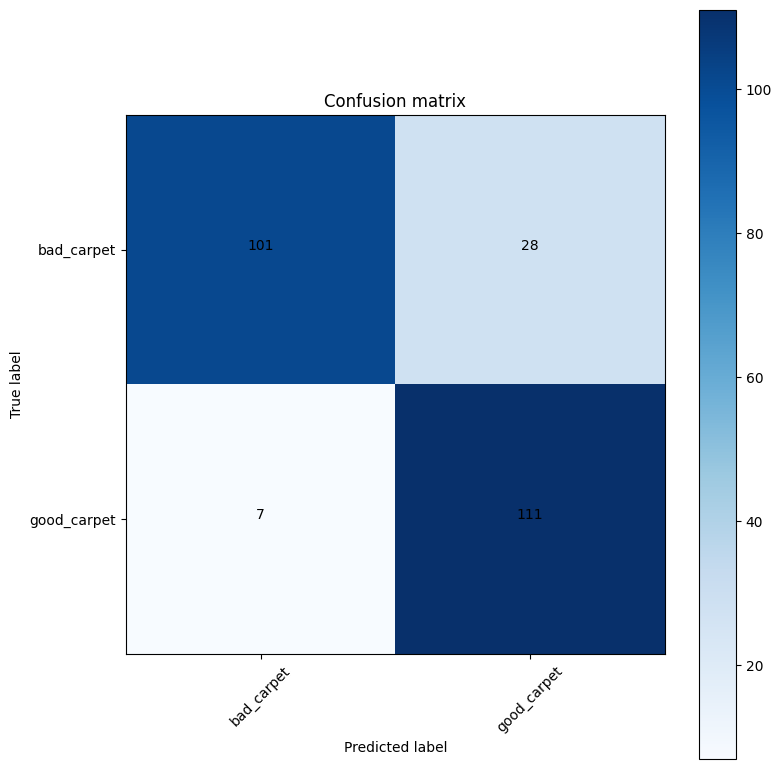

In [ ]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, classes, normalize=False)

              precision    recall  f1-score   support

           0       0.94      0.78      0.85       129
           1       0.80      0.94      0.86       118

    accuracy                           0.86       247
   macro avg       0.87      0.86      0.86       247
weighted avg       0.87      0.86      0.86       247

0.8582995951417004


<Axes: >

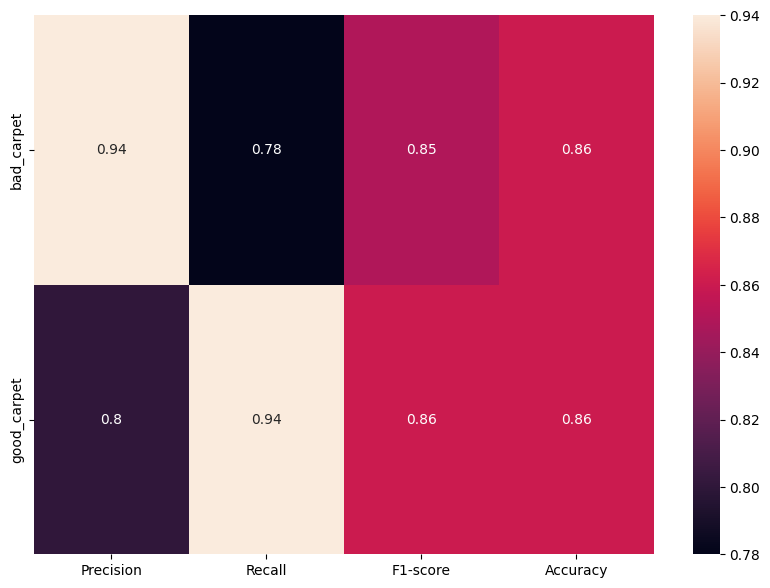

In [ ]:
print(classification_report(all_labels, all_preds))
print(accuracy_score(all_labels, all_preds))
report = pd.DataFrame(list(precision_recall_fscore_support(all_labels, all_preds)),
                          index=['Precision', 'Recall', 'F1-score', 'Support'],
                          columns=[i for i in classes]).T
accuracy = sum(cm.diagonal()) / (cm.sum(axis=1) + cm.sum(axis=0)+ sum(cm.diagonal()) - 2*cm.diagonal())
report['Accuracy'] = accuracy
report.drop('Support', axis=1, inplace=True)
acc = np.zeros(report.shape[0])

report = report.round(2)
plt.figure(figsize = (10,7))
sn.heatmap(report, annot=True)

In [ ]:
#Classification report
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_curve,f1_score,classification_report,auc
num_classes=2
c_labels = ["" for x in range(num_classes)]
for i in range(num_classes):
  c_labels[i]=classes[i]
print(classification_report(all_labels, all_preds, target_names=c_labels))

#ROC curve for each class

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
num_classes=2
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    y_true=label_binarize(all_labels, classes=[i])
    y_pred=label_binarize(all_preds, classes=[i])
    print(y_pred)
    fpr[i], tpr[i], _=roc_curve(y_true, y_pred, pos_label=1)
    roc_auc[i] = auc(fpr[i], tpr[i])


for i in range(num_classes):
  plt.plot(fpr[i], tpr[i],
          label='ROC curve of class {0} (area = {1:0.2f})'
          ''.format(classes[i], roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve for each class')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.65))
plt.show()

In [ ]:
#Learning Curves train/val
import matplotlib.pyplot as plt
epochs = 3  # Example, set this to your actual number of epochs
epochs_plot = list(range(1, epochs + 1))

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs_plot, history['train_loss'], label='Training Loss')
plt.plot(epochs_plot, history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs_plot, history['train_acc'], label='Training Accuracy')
plt.plot(epochs_plot, history['val_acc'], label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Cross Validation

In [ ]:
import copy
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset, ConcatDataset
from torchvision import datasets, models, transforms

# Assume dataset is a combination of your training and validation datasets
# Assume model is defined (for example, a modified ResNet)

# Initialize model and optimizer for each fold
model = torchvision.models.resnet101(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # 2 is the number of classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
k_folds = 5
num_epochs = 3
batch_size = 32

# Placeholder for results
fold_results = {}
epoch_results = {epoch: {'average_train_loss': [], 'average_train_acc': [], 'average_val_loss': [], 'average_val_acc': []} for epoch in range(num_epochs)}
best_overall_model = {'accuracy': 0, 'state_dict': None}

# Define your dataset and model
dataset = ConcatDataset([train_dataset, val_dataset])  # Example, ensure you have your datasets combined

def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    epoch_loss, running_loss, correct, total = 0.0, 0.0, 0, 0
    for  i, (inputs, labels) in enumerate(dataloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

         # print statistics
        running_loss += loss.item()
        epoch_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        if (i % 10) == 9:    # print every 10 mini-batches
              print('[Batch: %4d / %4d], training loss: %.3f' %
                  (i + 1, len(dataloader), running_loss / 10))
              running_loss = 0.0

    print('Training Loss: {:.4f}'.format(epoch_loss/len(dataloader)))
    train_loss = epoch_loss / len(dataloader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

def validate_epoch(model, dataloader, criterion):
    model.eval()
    validation_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print('Validation Loss: {:.4f}'.format(validation_loss/len(dataloader)))
    val_loss = validation_loss / len(dataloader)
    val_acc = 100. * correct / total
    return val_loss, val_acc, all_preds, all_labels

# K-Fold Cross Validation
kfold = KFold(n_splits=k_folds, shuffle=True)
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    # Prepare data loaders
    train_subsampler = Subset(dataset, train_ids)
    val_subsampler = Subset(dataset, test_ids)
    train_loader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subsampler, batch_size=batch_size, shuffle=False)

    # Initialize model and optimizer for each fold
    model = torchvision.models.resnet101(pretrained=True)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 2)  # 2 is the number of classes

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    best_val_acc = 0
    for epoch in range(num_epochs):
        #Print training summary
        print(f'[Fold: {fold}, Epoch: {epoch+1}/{num_epochs}]')

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
        print(f'[Fold: {fold}, Epoch: {epoch+1}/{num_epochs}] Training loss: {train_loss:.4f}, Training acc: {train_acc:.2f}%')

        val_loss, val_acc, val_preds, val_labels = validate_epoch(model, val_loader, criterion)
        print(f'[Fold: {fold}, Epoch: {epoch+1}/{num_epochs}] Validation loss: {val_loss:.4f}, Validation acc: {val_acc:.2f}%')

        # Update epoch results with averages later
        # Add train_loss, train_acc, val_loss, val_acc to epoch_results[epoch]

        if val_acc > best_val_acc:  # Check if this is the best model for this fold
            best_val_acc = val_acc
            fold_results[fold] = {
                'best_model_for_each_fold_across_all_epochs': copy.deepcopy(model.state_dict()),
                'all_preds_for_best_model_for_each_fold_across_all_epochs': val_preds,
                'all_labels_for_best_model_for_each_fold_across_all_epochs': val_labels,
                'acc_for_best_model_for_each_fold_across_all_epochs': best_val_acc,
            }

        # Update the epoch_results for averaging later
        epoch_results[epoch]['average_train_loss'].append(train_loss)
        epoch_results[epoch]['average_train_acc'].append(train_acc)
        epoch_results[epoch]['average_val_loss'].append(val_loss)
        epoch_results[epoch]['average_val_acc'].append(val_acc)

    # Update overall best model across all folds, if current fold's best model is better
    if best_val_acc > best_overall_model['accuracy']:
        best_overall_model['accuracy'] = best_val_acc
        best_overall_model['state_dict'] = copy.deepcopy(model.state_dict())

# After completing all folds, average out the epoch metrics
for epoch in epoch_results:
    epoch_metrics = epoch_results[epoch]
    epoch_metrics['average_train_loss'] = np.mean(epoch_metrics['average_train_loss'])
    epoch_metrics['average_train_acc'] = np.mean(epoch_metrics['average_train_acc'])
    epoch_metrics['average_val_loss'] = np.mean(epoch_metrics['average_val_loss'])
    epoch_metrics['average_val_acc'] = np.mean(epoch_metrics['average_val_acc'])

# Save the overall best model
torch.save(best_overall_model['state_dict'], 'best_model_across_all_folds.pth')


# Output or work with the results
#print("Fold results:", fold_results)
print("Epoch averages:", epoch_results)
print("Best overall model accuracy:", best_overall_model['accuracy'])


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Fold: 0, Epoch: 1/3]
[Batch:   10 /   56], training loss: 0.618
[Batch:   20 /   56], training loss: 0.488
[Batch:   30 /   56], training loss: 0.394
[Batch:   40 /   56], training loss: 0.366
[Batch:   50 /   56], training loss: 0.305
Training Loss: 0.4358
[Fold: 0, Epoch: 1/3] Training loss: 0.4358, Training acc: 79.69%
Validation Loss: 0.2741
[Fold: 0, Epoch: 1/3] Validation loss: 0.2741, Validation acc: 88.69%
[Fold: 0, Epoch: 2/3]
[Batch:   10 /   56], training loss: 0.316
[Batch:   20 /   56], training loss: 0.310
[Batch:   30 /   56], training loss: 0.283
[Batch:   40 /   56], training loss: 0.249
[Batch:   50 /   56], training loss: 0.303
Training Loss: 0.2929
[Fold: 0, Epoch: 2/3] Training loss: 0.2929, Training acc: 87.44%
Validation Loss: 0.2614
[Fold: 0, Epoch: 2/3] Validation loss: 0.2614, Validation acc: 89.37%
[Fold: 0, Epoch: 3/3]
[Batch:   10 /   56], training loss: 0.203
[Batch:   20 /   56], training loss: 0.195
[Batch:   30 /   56], training loss: 0.259
[Batch:   4

In [ ]:
fold_results[0]['acc_for_best_model_for_each_fold_across_all_epochs']

89.36651583710407

In [ ]:
best_overall_model['accuracy']

89.81900452488688

In [ ]:
epoch_results

{0: {'average_train_loss': 0.41971756134714394,
  'average_train_acc': 80.78054298642533,
  'average_val_loss': 0.3101174658962659,
  'average_val_acc': 87.82805429864254},
 1: {'average_train_loss': 0.28960173965564795,
  'average_train_acc': 88.20135746606336,
  'average_val_loss': 0.28726761756198743,
  'average_val_acc': 88.41628959276018},
 2: {'average_train_loss': 0.22481453360191414,
  'average_train_acc': 91.30090497737558,
  'average_val_loss': 0.28549003611717905,
  'average_val_acc': 88.50678733031675}}

In [ ]:
classes= train_dataset.classes
classes

['bad_carpet', 'good_carpet']

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming fold_results is populated as described in previous steps

confusion_matrices = []

for fold in fold_results:
    preds = fold_results[fold]['all_preds_for_best_model_for_each_fold_across_all_epochs']
    labels = fold_results[fold]['all_labels_for_best_model_for_each_fold_across_all_epochs']
    cm = confusion_matrix(labels, preds)
    confusion_matrices.append(cm)

# Calculate the mean confusion matrix
mean_cm = np.mean(confusion_matrices, axis=0)
# Rounding the elements of the mean confusion matrix to the nearest whole number
rounded_mean_cm = np.around(mean_cm).astype(int)
print("Mean Confusion Matrix:\n", rounded_mean_cm)

Mean Confusion Matrix:
 [[202  29]
 [ 19 192]]


Confusion matrix, without normalization


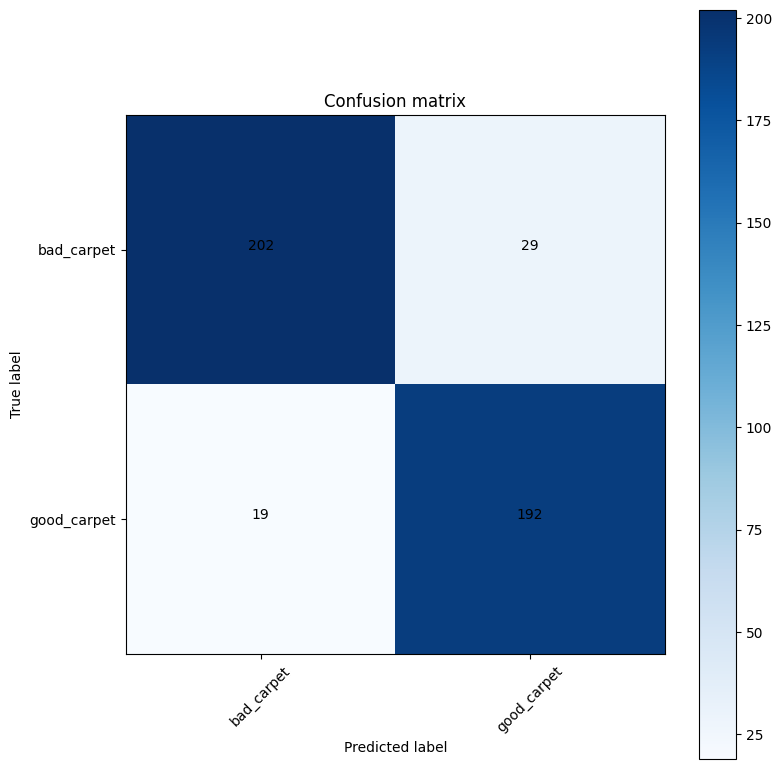

In [ ]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(rounded_mean_cm, classes, normalize=False)

              precision    recall  f1-score   support

           0       0.91      0.87      0.89      1155
           1       0.87      0.91      0.89      1055

    accuracy                           0.89      2210
   macro avg       0.89      0.89      0.89      2210
weighted avg       0.89      0.89      0.89      2210



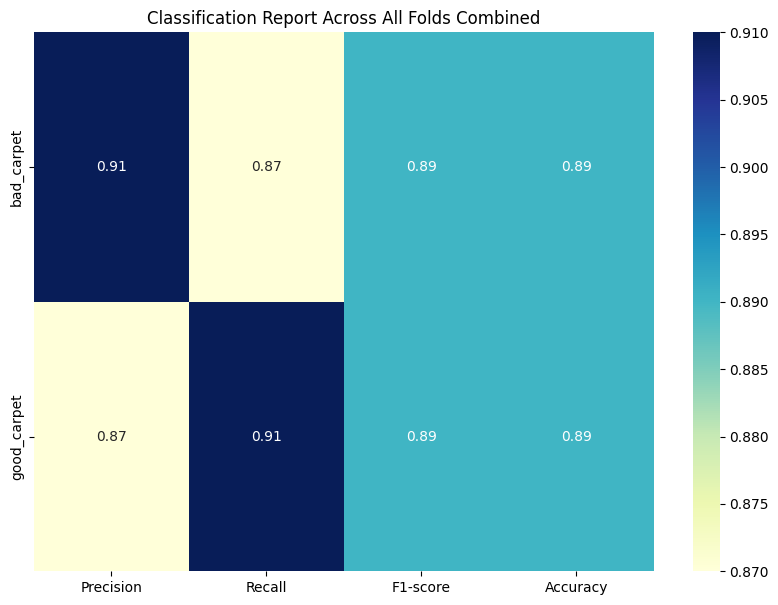

In [ ]:
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

all_preds = []
all_labels = []

# Assuming fold_results is populated
for fold in fold_results:
    all_preds.extend(fold_results[fold]['all_preds_for_best_model_for_each_fold_across_all_epochs'])
    all_labels.extend(fold_results[fold]['all_labels_for_best_model_for_each_fold_across_all_epochs'])

# Now calculate the metrics on the aggregated predictions and labels
print(classification_report(all_labels, all_preds))

# Calculate precision, recall, fscore
precision, recall, fscore, support = precision_recall_fscore_support(all_labels, all_preds, average=None, labels=[i for i in range(len(classes))])

# Calculate confusion matrix and then accuracy
cm = confusion_matrix(all_labels, all_preds)
accuracy = np.sum(cm.diagonal()) / np.sum(cm)

# Construct DataFrame for the report
report_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1-score': fscore
}, index=classes)

# Add accuracy to the DataFrame. Note: This accuracy is overall, not per class.
report_df['Accuracy'] = accuracy
report_df.drop('Support', axis=1, inplace=True, errors='ignore')
report_df = report_df.round(2)  # Rounding for display

# Visualization with heatmap
plt.figure(figsize=(10, 7))
sn.heatmap(report_df, annot=True, cmap="YlGnBu")
plt.title("Classification Report Across All Folds Combined")
plt.show()

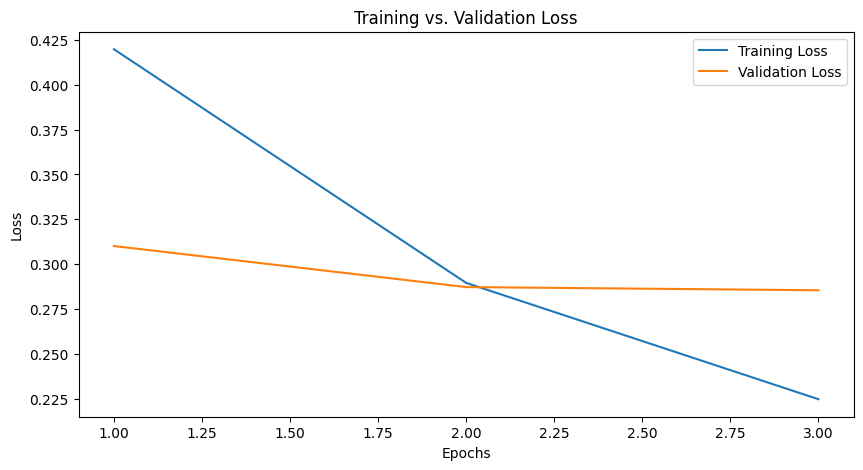

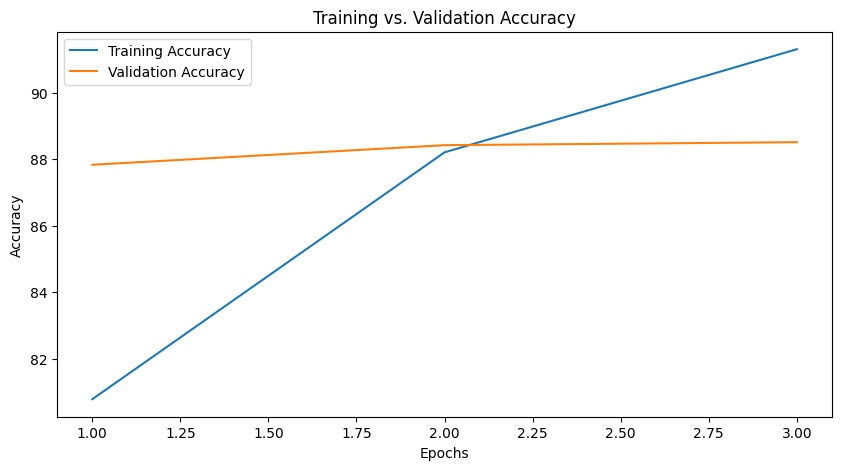

In [ ]:
import matplotlib.pyplot as plt

# Extracting values for plotting
train_loss = [epoch_results[epoch]['average_train_loss'] for epoch in epoch_results]
val_loss = [epoch_results[epoch]['average_val_loss'] for epoch in epoch_results]
train_acc = [epoch_results[epoch]['average_train_acc'] for epoch in epoch_results]
val_acc = [epoch_results[epoch]['average_val_acc'] for epoch in epoch_results]

epochs = len(epoch_results)  # Number of epochs
epochs_plot = list(range(1, epochs + 1))

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs_plot, train_loss, label='Training Loss')
plt.plot(epochs_plot, val_loss, label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs_plot, train_acc, label='Training Accuracy')
plt.plot(epochs_plot, val_acc, label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model.load_state_dict(torch.load('best_model_across_all_folds.pth'))
import torch

# Assuming test_loader, model, and criterion are already defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Initialize lists to store predictions, labels, and probabilities
all_preds = []
all_labels = []
all_probs = []

# Initialize variables for test loss and accuracy computation
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader, 0):
        print('Batch [%4d / %4d]' % (i+1, len(test_loader)))
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Convert outputs to probabilities
        probabilities = torch.softmax(outputs.data, dim=1)
        all_probs += list(probabilities.numpy())

        # Get predictions
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.numpy())
        all_labels += list(labels.numpy())

        # Update total and correct
        total += labels.size(0)
        correct += (preds == labels).sum().item()

# Compute the accuracy
accuracy = 100 * correct / total
print('Test Loss: {:.4f}'.format(test_loss / len(test_loader)))
print('Test Accuracy: {:.2f}%'.format(accuracy))

Batch [   1 /    8]
Batch [   2 /    8]
Batch [   3 /    8]
Batch [   4 /    8]
Batch [   5 /    8]
Batch [   6 /    8]
Batch [   7 /    8]
Batch [   8 /    8]
Test Loss: 0.3202
Test Accuracy: 90.28%


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score

cm = confusion_matrix(all_labels, all_preds);
cm

array([[120,   9],
       [ 15, 103]])

Confusion matrix, without normalization


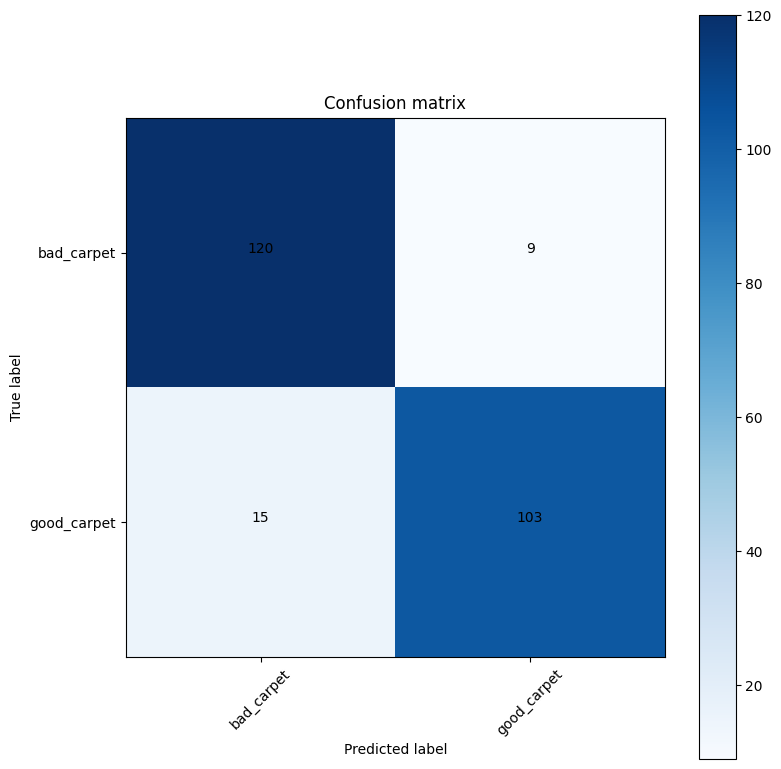

In [ ]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, classes, normalize=False)

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       129
           1       0.92      0.87      0.90       118

    accuracy                           0.90       247
   macro avg       0.90      0.90      0.90       247
weighted avg       0.90      0.90      0.90       247

0.902834008097166


<Axes: >

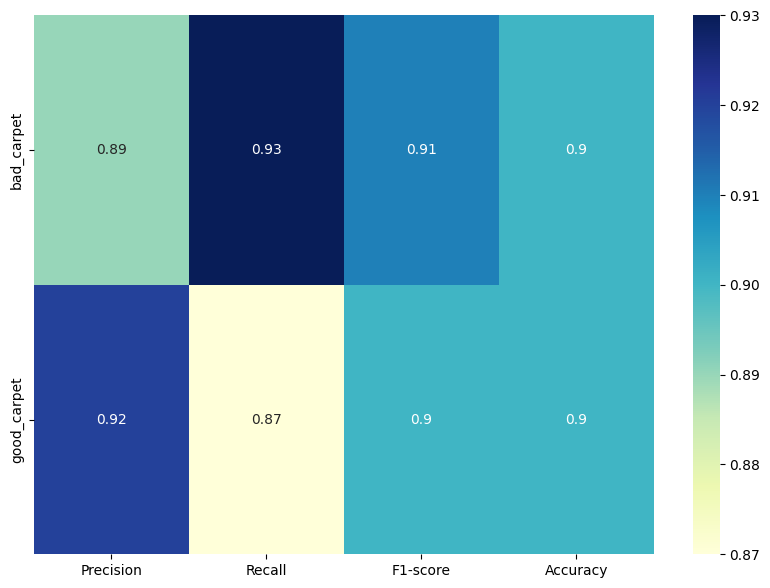

In [ ]:
print(classification_report(all_labels, all_preds))
print(accuracy_score(all_labels, all_preds))
report = pd.DataFrame(list(precision_recall_fscore_support(all_labels, all_preds)),
                          index=['Precision', 'Recall', 'F1-score', 'Support'],
                          columns=[i for i in classes]).T
accuracy = sum(cm.diagonal()) / (cm.sum(axis=1) + cm.sum(axis=0)+ sum(cm.diagonal()) - 2*cm.diagonal())
report['Accuracy'] = accuracy
report.drop('Support', axis=1, inplace=True)
acc = np.zeros(report.shape[0])

report = report.round(2)
plt.figure(figsize = (10,7))
sn.heatmap(report, annot=True, cmap="YlGnBu")
